In [4]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from util import training, ElmanRNN, JordanRNN, MultiRecurrentNN

from util import convert_feature_into_cyclic

def preprocess(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data.rename(columns={'Close/Last': 'ClosingPrice'}, inplace=True)
    data['ClosingPrice'] = data['ClosingPrice'].str.replace('$', '').astype(float)
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month
    data['Day'] = data['Date'].dt.day
    data['Weekday'] = data['Date'].dt.weekday
    print(f'Number of years: {data['Year'].max() - data['Year'].min() + 1}')
    convert_feature_into_cyclic(data, 'Year', 11)
    convert_feature_into_cyclic(data, 'Month', 12)
    convert_feature_into_cyclic(data, 'Day', 31)
    convert_feature_into_cyclic(data, 'Weekday', 7)
    data.drop(columns=['Volume', 'Open', 'High', 'Low', 'Date', 'Year', 'Month', 'Day', 'Weekday'], inplace=True)
    return data

# Read in the data

data = pd.read_csv('../csvs/apple.csv')
dates = pd.to_datetime(data['Date'])
data = preprocess(data)
data.head()

Number of years: 11


,ClosingPrice,YearSin,YearCos,MonthSin,MonthCos,DaySin,DayCos,WeekdaySin,WeekdayCos
0,238.99,0.540641,0.841254,-1.0,-1.836970e-16,-0.299363,-0.954139,0.974928,-0.222521
1,238.15,0.540641,0.841254,-1.0,-1.836970e-16,-0.101168,-0.994869,0.781831,0.623490
2,236.70,0.540641,0.841254,-1.0,-1.836970e-16,0.101168,-0.994869,0.000000,1.000000
3,234.07,0.540641,0.841254,-1.0,-1.836970e-16,0.651372,-0.758758,-0.433884,-0.900969
4,230.03,0.540641,0.841254,-1.0,-1.836970e-16,0.790776,-0.612106,0.433884,-0.900969


In [2]:
round(data.describe(), 2).to_csv('../csv-descriptions/summary-statistics-for-apple.csv')

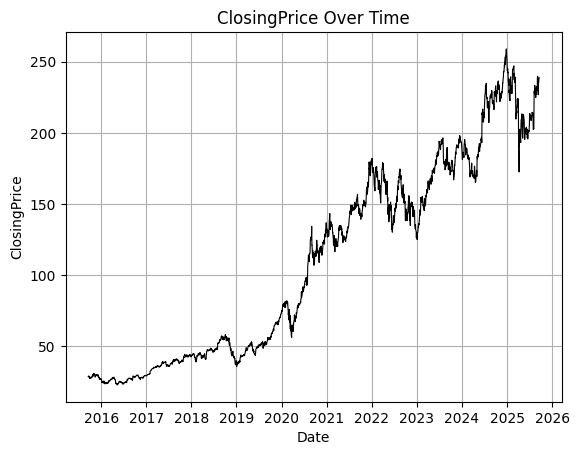

In [3]:
# Display some graphs

from util import plot_feature_over_time

plot_feature_over_time(data, 'ClosingPrice', save_path='../images/apple-closing-price-over-time.pdf', dates=dates)


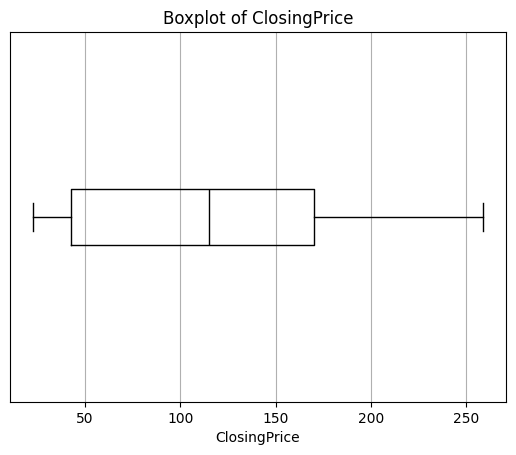

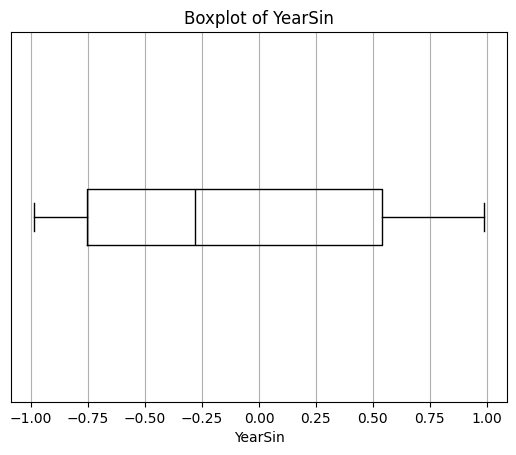

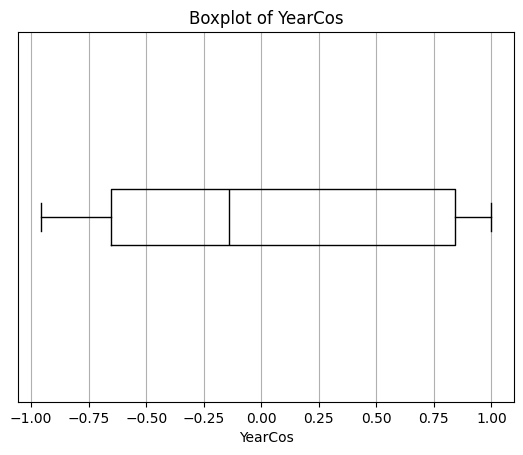

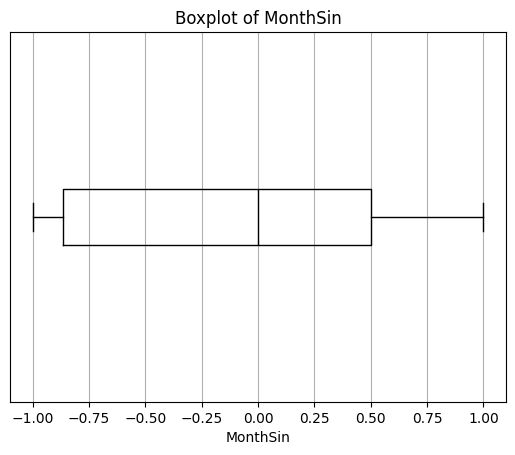

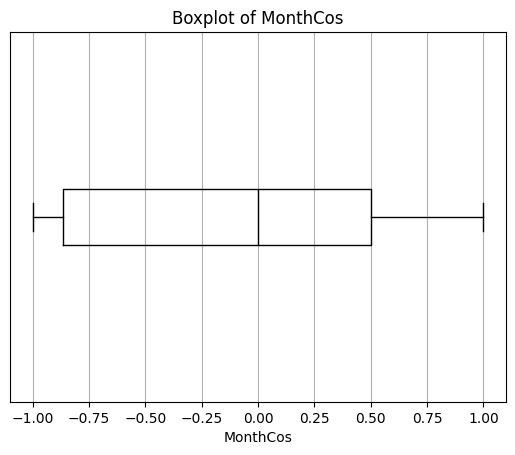

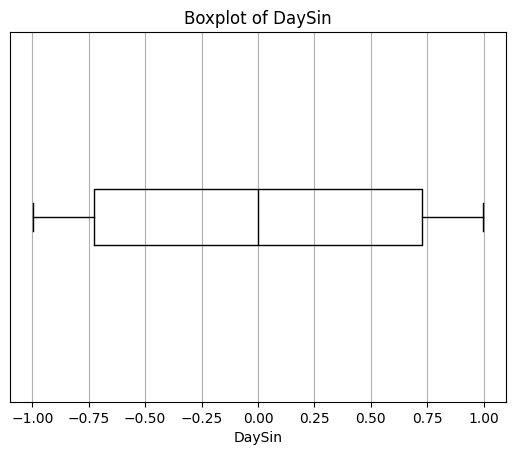

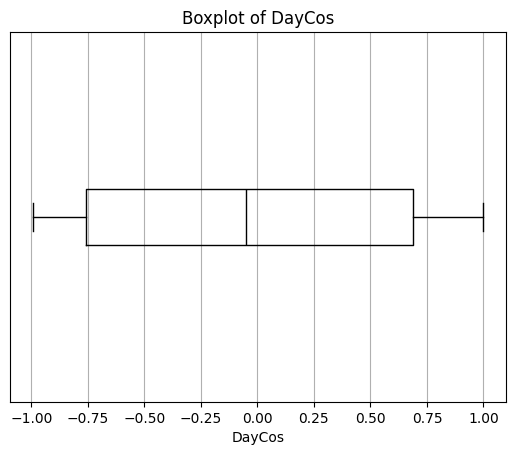

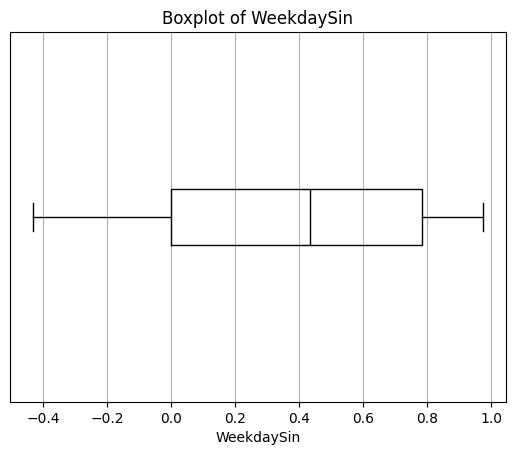

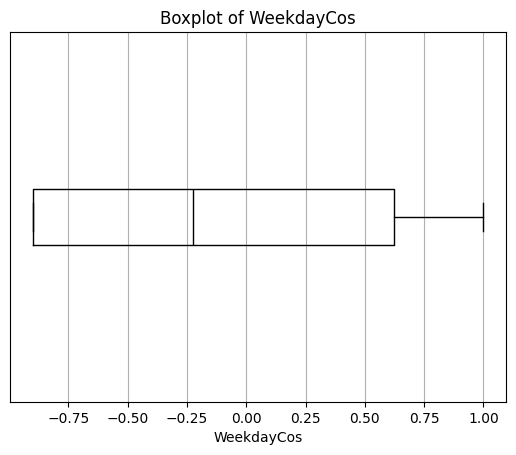

In [4]:
# Statistics of data

from util import plot_boxplot_of_feature

for feature in data.columns:
    plot_boxplot_of_feature(data, feature)


In [2]:
elman_rnn_cv_scores_h32 = training(model=ElmanRNN(input_size=8, hidden_size=32, output_size=1),
         data=data,
         target_feature_name='ClosingPrice',
         model_name='elman',
         learning_rate=0.002,
         patience=10,
         num_epochs=100)

NameError: name 'data' is not defined

(2514, 8)
(2514,)
(2451, 64, 8)
(2451,)
Train indices from 0 to 274 and validation indices from 275 to 546
Epoch [1/100], Loss: 48488.7385, Validation Loss: 32602.0645
Epoch [2/100], Loss: 48312.4696, Validation Loss: 32312.1372
Epoch [3/100], Loss: 47619.9670, Validation Loss: 31597.6734
Epoch [4/100], Loss: 46768.0753, Validation Loss: 30936.3716
Epoch [5/100], Loss: 45994.7602, Validation Loss: 30339.7258
Epoch [6/100], Loss: 45299.8577, Validation Loss: 29790.6695
Epoch [7/100], Loss: 44650.1521, Validation Loss: 29273.0520
Epoch [8/100], Loss: 44032.8915, Validation Loss: 28780.5859
Epoch [9/100], Loss: 43441.9406, Validation Loss: 28308.5057
Epoch [10/100], Loss: 42874.0486, Validation Loss: 27852.6808
Epoch [11/100], Loss: 42324.9640, Validation Loss: 27410.1838
Epoch [12/100], Loss: 41783.3670, Validation Loss: 26979.2898
Epoch [13/100], Loss: 41255.2516, Validation Loss: 26558.4444
Epoch [14/100], Loss: 40740.3302, Validation Loss: 26146.3387
Epoch [15/100], Loss: 40233.6632, 

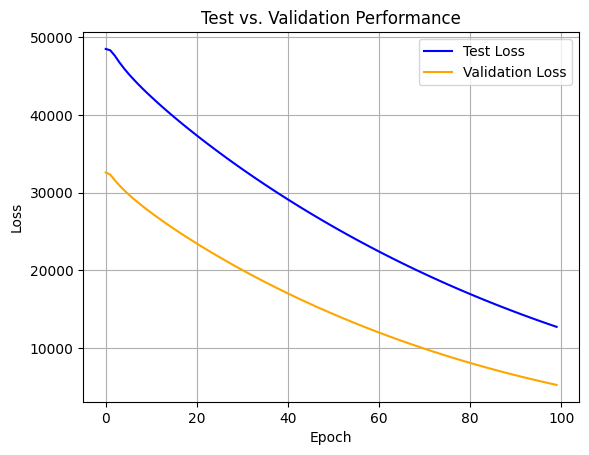

Train indices from 0 to 546 and validation indices from 547 to 818
Epoch [1/100], Loss: 8805.6043, Validation Loss: 1769.4434
Epoch [2/100], Loss: 8428.2875, Validation Loss: 1600.3920
Epoch [3/100], Loss: 8056.9830, Validation Loss: 1441.7681
Epoch [4/100], Loss: 7695.7397, Validation Loss: 1293.5021
Epoch [5/100], Loss: 7346.4028, Validation Loss: 1155.6048
Epoch [6/100], Loss: 7009.4946, Validation Loss: 1027.9303
Epoch [7/100], Loss: 6685.0974, Validation Loss: 910.2624
Epoch [8/100], Loss: 6373.1004, Validation Loss: 802.3378
Epoch [9/100], Loss: 6073.3119, Validation Loss: 703.8444
Epoch [10/100], Loss: 5785.4935, Validation Loss: 614.4742
Epoch [11/100], Loss: 5509.3758, Validation Loss: 533.9084
Epoch [12/100], Loss: 5244.6715, Validation Loss: 461.8352
Epoch [13/100], Loss: 4991.0874, Validation Loss: 397.9331
Epoch [14/100], Loss: 4748.3282, Validation Loss: 341.8860
Epoch [15/100], Loss: 4516.0914, Validation Loss: 293.3781
Epoch [16/100], Loss: 4294.0780, Validation Loss: 2

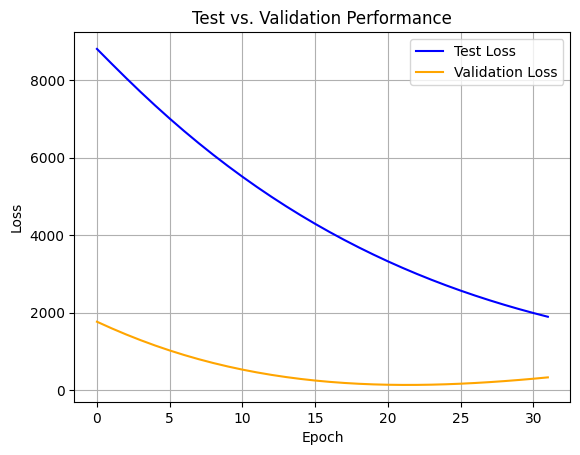

Train indices from 0 to 818 and validation indices from 819 to 1090
Epoch [1/100], Loss: 1331.4404, Validation Loss: 707.5747
Epoch [2/100], Loss: 1282.2887, Validation Loss: 765.1993
Epoch [3/100], Loss: 1239.8303, Validation Loss: 824.5531
Epoch [4/100], Loss: 1202.0155, Validation Loss: 47904.3043
Epoch [5/100], Loss: 1168.6000, Validation Loss: 52808.6095
Epoch [6/100], Loss: 10127.1574, Validation Loss: 54813.9892
Epoch [7/100], Loss: 9947.2810, Validation Loss: 53117.0525
Epoch [8/100], Loss: 1744.0826, Validation Loss: 52927.4515
Epoch [9/100], Loss: 1037.9182, Validation Loss: 53242.9042
Epoch [10/100], Loss: 1002.7980, Validation Loss: 53583.2037
Epoch [11/100], Loss: 967.4738, Validation Loss: 53933.5342
Early stopping at epoch 11
Best epoch: 1, Best validation loss: 707.5747


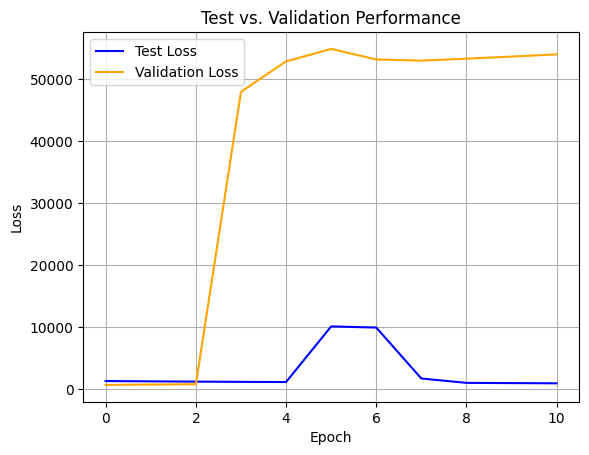

Train indices from 0 to 1090 and validation indices from 1091 to 1362
Epoch [1/100], Loss: 1075.2890, Validation Loss: 39297.9307
Epoch [2/100], Loss: 4829.5143, Validation Loss: 42284.3936
Epoch [3/100], Loss: 1374.9595, Validation Loss: 39949.3005
Epoch [4/100], Loss: 755.9698, Validation Loss: 37867.3901
Epoch [5/100], Loss: 717.6477, Validation Loss: 37184.0267
Epoch [6/100], Loss: 686.4596, Validation Loss: 36515.1513
Epoch [7/100], Loss: 658.0803, Validation Loss: 35800.9417
Epoch [8/100], Loss: 630.7054, Validation Loss: 34487.0300
Epoch [9/100], Loss: 607.0811, Validation Loss: 33953.3844
Epoch [10/100], Loss: 586.3724, Validation Loss: 33201.0122
Epoch [11/100], Loss: 568.0098, Validation Loss: 33034.4326
Epoch [12/100], Loss: 551.3672, Validation Loss: 33053.6899
Epoch [13/100], Loss: 536.1419, Validation Loss: 32636.9289
Epoch [14/100], Loss: 521.0081, Validation Loss: 33041.1517
Epoch [15/100], Loss: 503.1889, Validation Loss: 33034.6334
Epoch [16/100], Loss: 482.6376, Vali

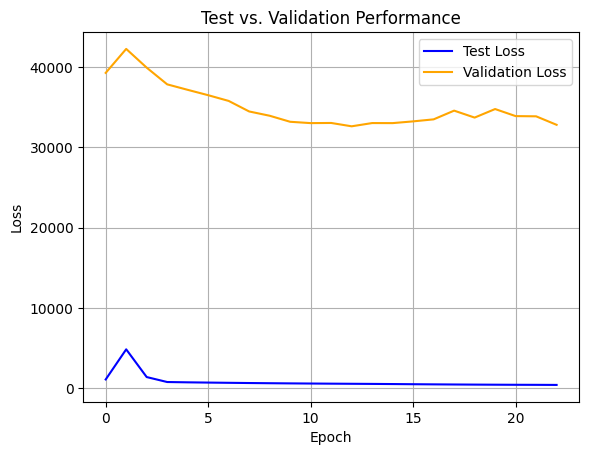

Train indices from 0 to 1362 and validation indices from 1363 to 1634
Epoch [1/100], Loss: 609.8586, Validation Loss: 5342.1107
Epoch [2/100], Loss: 517.1752, Validation Loss: 4844.5978
Epoch [3/100], Loss: 485.1134, Validation Loss: 6445.0186
Epoch [4/100], Loss: 797.1954, Validation Loss: 11462.1256
Epoch [5/100], Loss: 1372.4040, Validation Loss: 19464.1902
Epoch [6/100], Loss: 2179.6009, Validation Loss: 24305.7552
Epoch [7/100], Loss: 2265.7843, Validation Loss: 28917.4801
Epoch [8/100], Loss: 2136.8319, Validation Loss: 25375.1104
Epoch [9/100], Loss: 2033.8973, Validation Loss: 21554.8168
Epoch [10/100], Loss: 1416.6549, Validation Loss: 11076.4531
Epoch [11/100], Loss: 1136.1961, Validation Loss: 6711.3652
Epoch [12/100], Loss: 1195.8005, Validation Loss: 5706.1653
Early stopping at epoch 12
Best epoch: 2, Best validation loss: 4844.5978


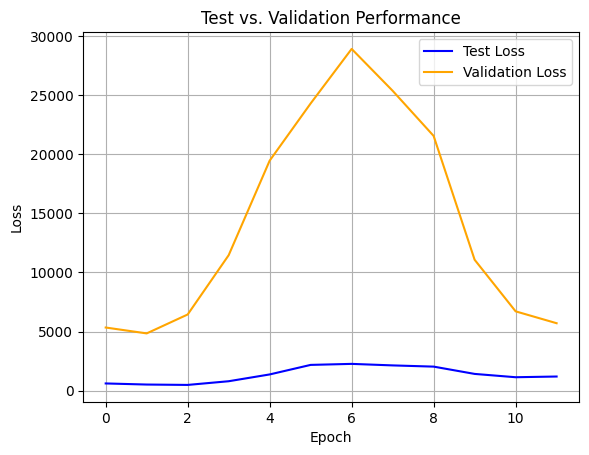

Train indices from 0 to 1634 and validation indices from 1635 to 1906
Epoch [1/100], Loss: 1415.0013, Validation Loss: 8603.5794
Epoch [2/100], Loss: 1799.0773, Validation Loss: 7643.5799
Epoch [3/100], Loss: 1369.1345, Validation Loss: 5256.5454
Epoch [4/100], Loss: 1186.0881, Validation Loss: 4320.7543
Epoch [5/100], Loss: 793.1257, Validation Loss: 2439.0237
Epoch [6/100], Loss: 644.4187, Validation Loss: 1284.2755
Epoch [7/100], Loss: 635.0268, Validation Loss: 1260.7180
Epoch [8/100], Loss: 1120.9103, Validation Loss: 851.4541
Epoch [9/100], Loss: 763.0331, Validation Loss: 660.9307
Epoch [10/100], Loss: 384.9918, Validation Loss: 604.3125
Epoch [11/100], Loss: 413.6539, Validation Loss: 653.9311
Epoch [12/100], Loss: 267.9097, Validation Loss: 626.7066
Epoch [13/100], Loss: 242.8176, Validation Loss: 533.4134
Epoch [14/100], Loss: 259.7875, Validation Loss: 567.1399
Epoch [15/100], Loss: 243.4646, Validation Loss: 586.0416
Epoch [16/100], Loss: 231.5463, Validation Loss: 563.8771

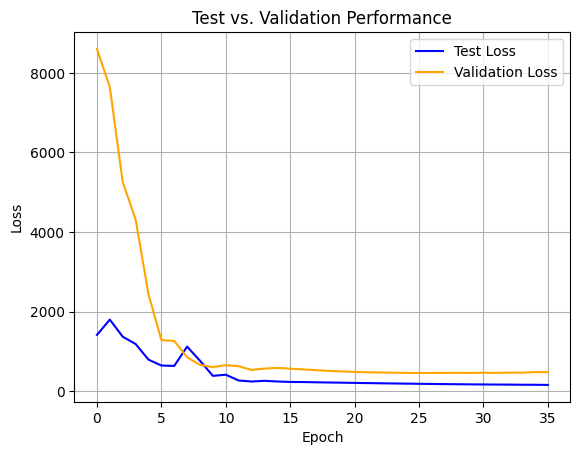

Train indices from 0 to 1906 and validation indices from 1907 to 2178
Epoch [1/100], Loss: 255.1049, Validation Loss: 6486.5521
Epoch [2/100], Loss: 297.8942, Validation Loss: 5726.2625
Epoch [3/100], Loss: 247.2581, Validation Loss: 5432.2827
Epoch [4/100], Loss: 216.0376, Validation Loss: 5133.3240
Epoch [5/100], Loss: 198.5523, Validation Loss: 4897.7749
Epoch [6/100], Loss: 187.2590, Validation Loss: 4596.5770
Epoch [7/100], Loss: 178.6341, Validation Loss: 4292.8128
Epoch [8/100], Loss: 171.9803, Validation Loss: 4009.3015
Epoch [9/100], Loss: 166.6473, Validation Loss: 3763.6857
Epoch [10/100], Loss: 162.2770, Validation Loss: 3558.9623
Epoch [11/100], Loss: 158.5761, Validation Loss: 3390.1925
Epoch [12/100], Loss: 155.3473, Validation Loss: 3250.4604
Epoch [13/100], Loss: 152.4690, Validation Loss: 3133.6034
Epoch [14/100], Loss: 149.8675, Validation Loss: 3034.6423
Epoch [15/100], Loss: 147.4945, Validation Loss: 2949.6106
Epoch [16/100], Loss: 145.3158, Validation Loss: 2875.

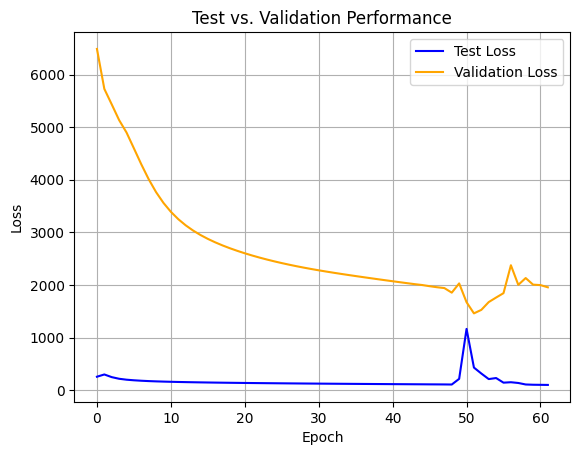

Train indices from 0 to 2178 and validation indices from 2179 to 2450
Epoch [1/100], Loss: 262.8935, Validation Loss: 6573.8105
Epoch [2/100], Loss: 722.2873, Validation Loss: 8054.5462
Epoch [3/100], Loss: 299.0163, Validation Loss: 7353.0007
Epoch [4/100], Loss: 197.8390, Validation Loss: 6380.5786
Epoch [5/100], Loss: 163.4105, Validation Loss: 5753.6087
Epoch [6/100], Loss: 151.9680, Validation Loss: 5360.9672
Epoch [7/100], Loss: 145.3031, Validation Loss: 5075.5298
Epoch [8/100], Loss: 139.6248, Validation Loss: 4840.9011
Epoch [9/100], Loss: 134.5838, Validation Loss: 4629.8592
Epoch [10/100], Loss: 129.9710, Validation Loss: 4445.9283
Epoch [11/100], Loss: 125.7654, Validation Loss: 4276.5572
Epoch [12/100], Loss: 122.1245, Validation Loss: 4130.6882
Epoch [13/100], Loss: 119.1071, Validation Loss: 4004.8990
Epoch [14/100], Loss: 116.5268, Validation Loss: 3886.7130
Epoch [15/100], Loss: 114.4107, Validation Loss: 3782.7582
Epoch [16/100], Loss: 112.6074, Validation Loss: 3694.

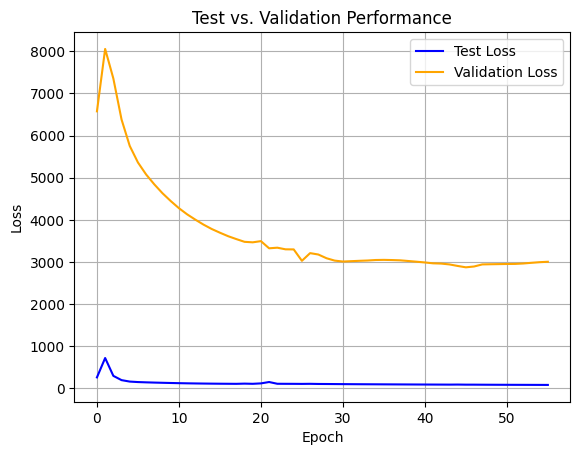

In [12]:
jordan_cv_scores_h32 =training(model=JordanRNN(input_size=8, hidden_size=32, output_size=1, state_size=16),
         data=data,
         target_feature_name='ClosingPrice',
         model_name='jordan',
         num_epochs=100,
         patience=10)

(2514, 8)
(2514,)
(2451, 64, 8)
(2451,)
Train indices from 0 to 274 and validation indices from 275 to 546
Epoch [1/100], Loss: 47766.5197, Validation Loss: 31599.5462
Epoch [2/100], Loss: 46783.1059, Validation Loss: 30899.1460
Epoch [3/100], Loss: 45886.1446, Validation Loss: 30139.2474
Epoch [4/100], Loss: 44951.0576, Validation Loss: 29364.4656
Epoch [5/100], Loss: 44007.7104, Validation Loss: 28610.3176
Epoch [6/100], Loss: 43096.3683, Validation Loss: 27883.8761
Epoch [7/100], Loss: 42214.1938, Validation Loss: 27180.2210
Epoch [8/100], Loss: 41355.6113, Validation Loss: 26495.5348
Epoch [9/100], Loss: 40516.9246, Validation Loss: 25827.4635
Epoch [10/100], Loss: 39695.8379, Validation Loss: 25174.4995
Epoch [11/100], Loss: 38890.8506, Validation Loss: 24535.6095
Epoch [12/100], Loss: 38100.9116, Validation Loss: 23910.0401
Epoch [13/100], Loss: 37325.2427, Validation Loss: 23297.2155
Epoch [14/100], Loss: 36563.2372, Validation Loss: 22696.6378
Epoch [15/100], Loss: 35808.0151, 

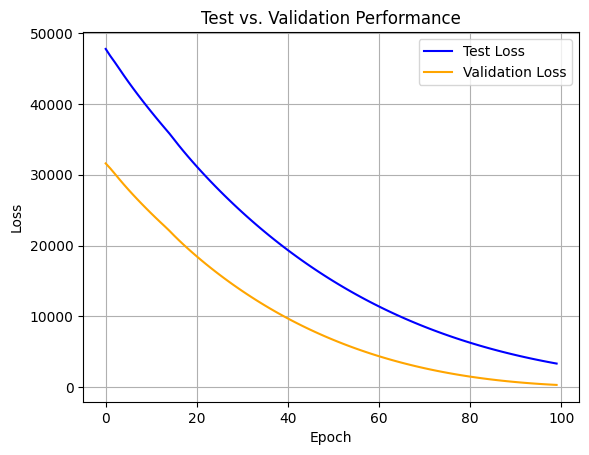

Train indices from 0 to 546 and validation indices from 547 to 818
Epoch [1/100], Loss: 1732.6466, Validation Loss: 445.3810
Epoch [2/100], Loss: 1541.3058, Validation Loss: 557.5192
Epoch [3/100], Loss: 1375.3543, Validation Loss: 681.1372
Epoch [4/100], Loss: 1232.8641, Validation Loss: 811.5708
Epoch [5/100], Loss: 1113.1847, Validation Loss: 945.0949
Epoch [6/100], Loss: 1014.0358, Validation Loss: 1078.6464
Epoch [7/100], Loss: 932.7623, Validation Loss: 1209.7167
Epoch [8/100], Loss: 866.7421, Validation Loss: 1336.3075
Epoch [9/100], Loss: 813.5476, Validation Loss: 1456.8810
Epoch [10/100], Loss: 771.0050, Validation Loss: 1570.3383
Epoch [11/100], Loss: 737.2098, Validation Loss: 1675.9408
Early stopping at epoch 11
Best epoch: 1, Best validation loss: 445.3810


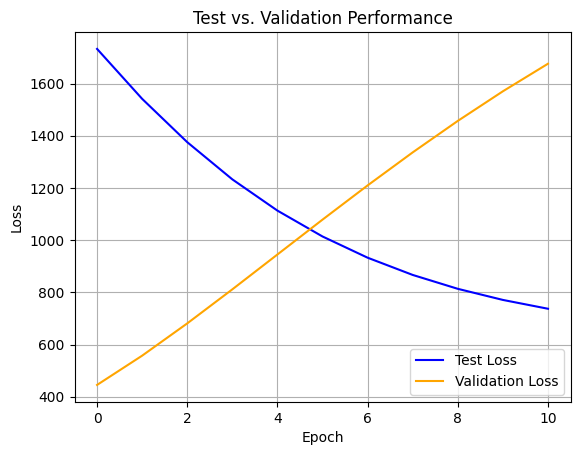

Train indices from 0 to 818 and validation indices from 819 to 1090
Epoch [1/100], Loss: 1070.9225, Validation Loss: 2242.1997
Epoch [2/100], Loss: 1036.6889, Validation Loss: 2120.3622
Epoch [3/100], Loss: 1025.5194, Validation Loss: 2024.6002
Epoch [4/100], Loss: 1018.7841, Validation Loss: 1948.7053
Epoch [5/100], Loss: 1014.8488, Validation Loss: 1888.2123
Epoch [6/100], Loss: 1012.6760, Validation Loss: 1839.8174
Epoch [7/100], Loss: 1011.5936, Validation Loss: 1800.9953
Epoch [8/100], Loss: 1011.1672, Validation Loss: 1769.7827
Epoch [9/100], Loss: 1011.1243, Validation Loss: 1744.6530
Epoch [10/100], Loss: 1011.2891, Validation Loss: 1724.3974
Epoch [11/100], Loss: 1011.5555, Validation Loss: 1708.0482
Epoch [12/100], Loss: 1011.8597, Validation Loss: 1694.8480
Epoch [13/100], Loss: 1012.1654, Validation Loss: 1684.1807
Epoch [14/100], Loss: 1012.4530, Validation Loss: 1675.5648
Epoch [15/100], Loss: 1012.7116, Validation Loss: 1668.6020
Epoch [16/100], Loss: 1012.9386, Validati

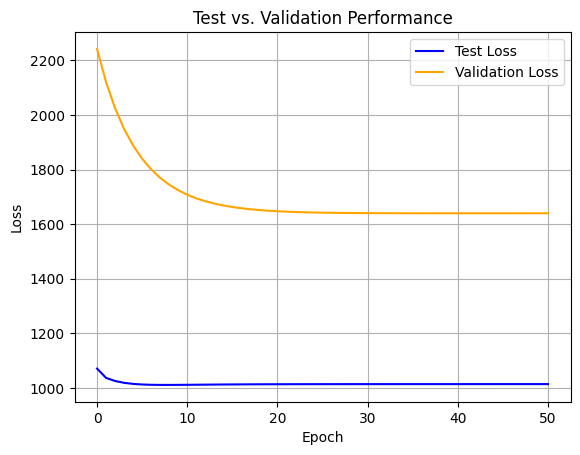

Train indices from 0 to 1090 and validation indices from 1091 to 1362
Epoch [1/100], Loss: 1200.9422, Validation Loss: 7384.6709
Epoch [2/100], Loss: 1149.0976, Validation Loss: 7033.7069
Epoch [3/100], Loss: 1130.8386, Validation Loss: 6772.4058
Epoch [4/100], Loss: 1121.5622, Validation Loss: 6575.1360
Epoch [5/100], Loss: 1117.2627, Validation Loss: 6425.3616
Epoch [6/100], Loss: 1115.6483, Validation Loss: 6311.2805
Epoch [7/100], Loss: 1115.4192, Validation Loss: 6224.2362
Epoch [8/100], Loss: 1115.8458, Validation Loss: 6157.7531
Epoch [9/100], Loss: 1116.5345, Validation Loss: 6106.9518
Epoch [10/100], Loss: 1117.2770, Validation Loss: 6068.1306
Epoch [11/100], Loss: 1117.9737, Validation Loss: 6038.4753
Epoch [12/100], Loss: 1118.5839, Validation Loss: 6015.8299
Epoch [13/100], Loss: 1119.0988, Validation Loss: 5998.5561
Epoch [14/100], Loss: 1119.5206, Validation Loss: 5985.4080
Epoch [15/100], Loss: 1119.8591, Validation Loss: 5975.4097
Epoch [16/100], Loss: 1120.1282, Valida

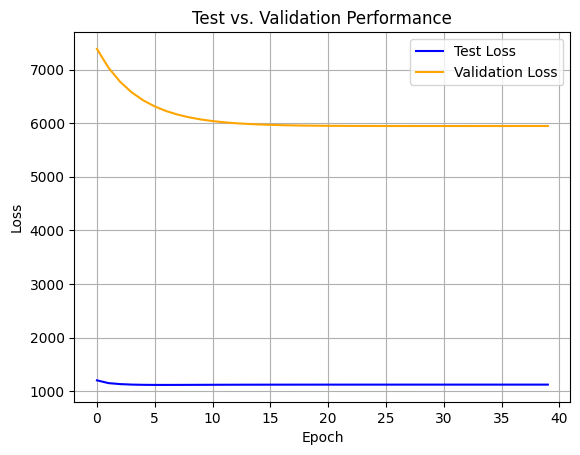

Train indices from 0 to 1362 and validation indices from 1363 to 1634
Epoch [1/100], Loss: 2135.8482, Validation Loss: 14305.3973
Epoch [2/100], Loss: 2034.8668, Validation Loss: 13578.0303
Epoch [3/100], Loss: 1993.6390, Validation Loss: 13038.1402
Epoch [4/100], Loss: 1971.3713, Validation Loss: 12626.5637
Epoch [5/100], Loss: 1959.9199, Validation Loss: 12309.7112
Epoch [6/100], Loss: 1954.6018, Validation Loss: 12064.5614
Epoch [7/100], Loss: 1952.6788, Validation Loss: 11874.3427
Epoch [8/100], Loss: 1952.5538, Validation Loss: 11726.4769
Epoch [9/100], Loss: 1953.3063, Validation Loss: 11611.4179
Epoch [10/100], Loss: 1954.4179, Validation Loss: 11521.8282
Epoch [11/100], Loss: 1955.6087, Validation Loss: 11452.0415
Epoch [12/100], Loss: 1956.7399, Validation Loss: 11397.7092
Epoch [13/100], Loss: 1957.7442, Validation Loss: 11355.4082
Epoch [14/100], Loss: 1958.6049, Validation Loss: 11322.4977
Epoch [15/100], Loss: 1959.3230, Validation Loss: 11296.9083
Epoch [16/100], Loss: 19

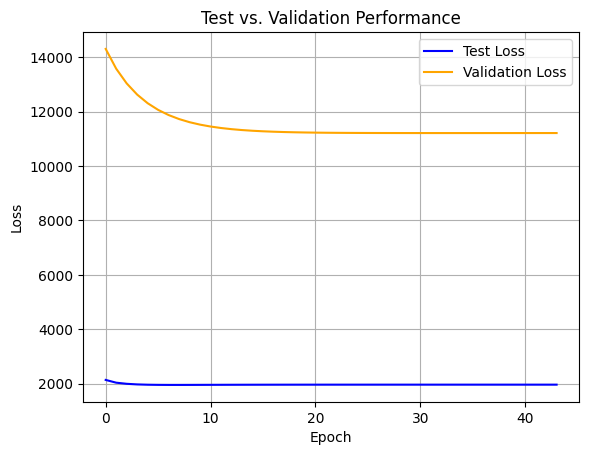

Train indices from 0 to 1634 and validation indices from 1635 to 1906
Epoch [1/100], Loss: 3533.3091, Validation Loss: 11809.0393
Epoch [2/100], Loss: 3408.6191, Validation Loss: 11077.5514
Epoch [3/100], Loss: 3353.9027, Validation Loss: 10528.6068
Epoch [4/100], Loss: 3322.8805, Validation Loss: 10104.6174
Epoch [5/100], Loss: 3305.9779, Validation Loss: 9773.3857
Epoch [6/100], Loss: 3297.4591, Validation Loss: 9512.9993
Epoch [7/100], Loss: 3293.8347, Validation Loss: 9307.4816
Epoch [8/100], Loss: 3292.9802, Validation Loss: 9144.8435
Epoch [9/100], Loss: 3293.6010, Validation Loss: 9015.8775
Epoch [10/100], Loss: 3294.9365, Validation Loss: 8913.4768
Epoch [11/100], Loss: 3296.5419, Validation Loss: 8832.1036
Epoch [12/100], Loss: 3298.1682, Validation Loss: 8767.3879
Epoch [13/100], Loss: 3299.6906, Validation Loss: 8715.9282
Epoch [14/100], Loss: 3301.0458, Validation Loss: 8674.9862
Epoch [15/100], Loss: 3302.2169, Validation Loss: 8642.4143
Epoch [16/100], Loss: 3303.2133, Va

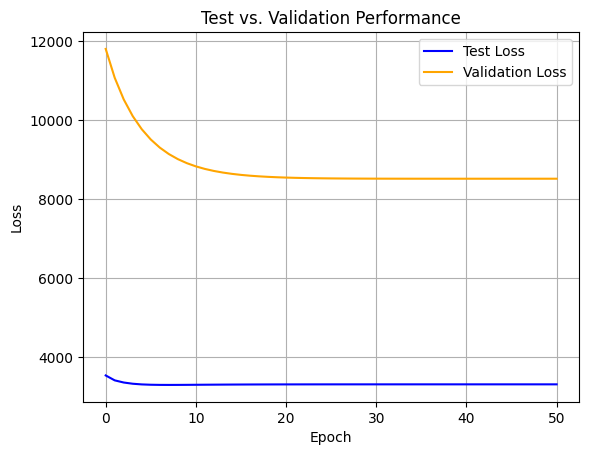

Train indices from 0 to 1906 and validation indices from 1907 to 2178
Epoch [1/100], Loss: 4035.3259, Validation Loss: 10473.7683
Epoch [2/100], Loss: 3966.4470, Validation Loss: 9905.8811
Epoch [3/100], Loss: 3943.1482, Validation Loss: 9487.7240
Epoch [4/100], Loss: 3932.4172, Validation Loss: 9170.9371
Epoch [5/100], Loss: 3928.6599, Validation Loss: 8928.0635
Epoch [6/100], Loss: 3928.5697, Validation Loss: 8740.6101
Epoch [7/100], Loss: 3930.2613, Validation Loss: 8595.3664
Epoch [8/100], Loss: 3932.6663, Validation Loss: 8482.5034
Epoch [9/100], Loss: 3935.2259, Validation Loss: 8394.6714
Epoch [10/100], Loss: 3937.6421, Validation Loss: 8326.2319
Epoch [11/100], Loss: 3939.7890, Validation Loss: 8272.8626
Epoch [12/100], Loss: 3941.6285, Validation Loss: 8231.2452
Epoch [13/100], Loss: 3943.1679, Validation Loss: 8198.7968
Epoch [14/100], Loss: 3944.4302, Validation Loss: 8173.5026
Epoch [15/100], Loss: 3945.4623, Validation Loss: 8153.8353
Epoch [16/100], Loss: 3946.2878, Valid

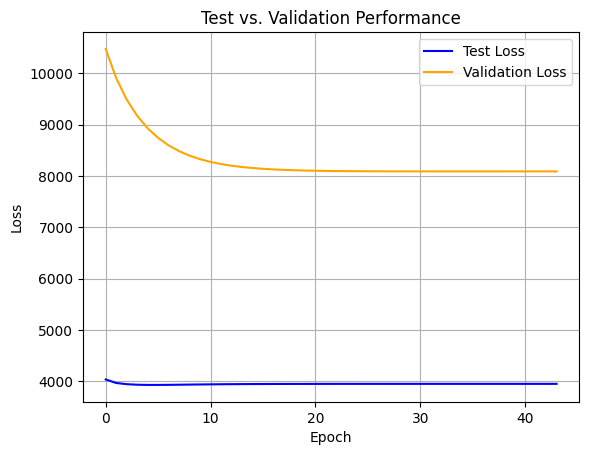

Train indices from 0 to 2178 and validation indices from 2179 to 2450
Epoch [1/100], Loss: 4447.5042, Validation Loss: 9337.9508
Epoch [2/100], Loss: 4410.9929, Validation Loss: 8845.9776
Epoch [3/100], Loss: 4403.0415, Validation Loss: 8495.8645
Epoch [4/100], Loss: 4402.0208, Validation Loss: 8238.0097
Epoch [5/100], Loss: 4404.4131, Validation Loss: 8045.4033
Epoch [6/100], Loss: 4408.1332, Validation Loss: 7900.4559
Epoch [7/100], Loss: 4412.0965, Validation Loss: 7790.8958
Epoch [8/100], Loss: 4415.7896, Validation Loss: 7707.8898
Epoch [9/100], Loss: 4418.9965, Validation Loss: 7644.8776
Epoch [10/100], Loss: 4421.6786, Validation Loss: 7597.0323
Epoch [11/100], Loss: 4423.8655, Validation Loss: 7560.7070
Epoch [12/100], Loss: 4425.6151, Validation Loss: 7533.1466
Epoch [13/100], Loss: 4426.9970, Validation Loss: 7512.2696
Epoch [14/100], Loss: 4428.0789, Validation Loss: 7496.4861
Epoch [15/100], Loss: 4428.9169, Validation Loss: 7484.5720
Epoch [16/100], Loss: 4429.5641, Valida

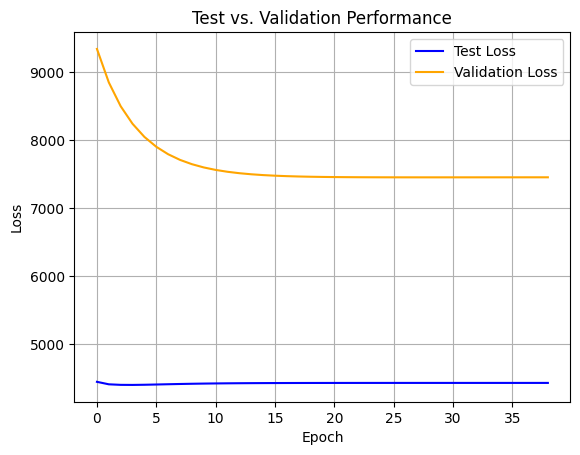

In [ ]:
multirecurrentrnn_cv_scores_h32 = training(model=MultiRecurrentNN(input_size=8, hidden_size=32, output_size=1, memory_config=[4, 4, 4], dropout=0.2),
                                            data=data,
                                            target_feature_name='ClosingPrice',
                                            model_name='multirecurrent',
                                            num_epochs=100,
                                            patience=10,
                                            learning_rate=0.005)

In [13]:
def describe_cv_results(cv_scores, model_name):
    mean_score = np.mean(cv_scores)
    median_score = np.median(cv_scores)
    std_score = np.std(cv_scores)
    return pd.DataFrame([{
        'Model': model_name,
        'Mean': mean_score,
        'Median': median_score,
        'Std. Deviation': std_score
    }])

In [ ]:
print(elman_rnn_cv_scores_h32)
print(jordan_cv_scores_h32)
print(multirecurrentrnn_cv_scores_h32)




results_df = describe_cv_results(elman_rnn_cv_scores_h32, 'Elman RNN with 32 hidden units')
results_df = pd.concat([results_df, describe_cv_results(jordan_cv_scores_h32, 'Jordan RNN with 32 hidden units')], ignore_index=True)
results_df = pd.concat([results_df, describe_cv_results(multirecurrentrnn_cv_scores_h32, 'Multi-Recurrent RNN with 32 hidden units')], ignore_index=True)
results_df.round(2).to_csv('../csv-descriptions/cv-results-apple.csv', index=False)

[80.00445545420928, 29692.33415670956, 284.10598283655503, 2002.6711757884307, 950.2600179560044, 435.9122751179863, 1815.7800948199103, 7293.292764102712]


NameError: name 'jordan_cv_scores_h32' is not defined

(2514, 8)
(2514,)
(2451, 64, 8)
(2451,)
Train indices from 0 to 274 and validation indices from 275 to 546
Epoch [1/200], Loss: 48491.4944, Validation Loss: 32643.4179
Epoch [2/200], Loss: 48246.9138, Validation Loss: 32411.0897
Epoch [3/200], Loss: 47806.4125, Validation Loss: 31887.4755
Epoch [4/200], Loss: 47039.1250, Validation Loss: 31167.9755
Epoch [5/200], Loss: 46275.9839, Validation Loss: 30520.0900
Epoch [6/200], Loss: 45491.2437, Validation Loss: 29957.4428
Epoch [7/200], Loss: 44766.1963, Validation Loss: 29358.0934
Epoch [8/200], Loss: 44089.9049, Validation Loss: 28814.0711
Epoch [9/200], Loss: 43444.0144, Validation Loss: 28306.9903
Epoch [10/200], Loss: 42831.9692, Validation Loss: 27821.6600
Epoch [11/200], Loss: 42261.0477, Validation Loss: 27357.1185
Epoch [12/200], Loss: 41706.0720, Validation Loss: 26906.0774
Epoch [13/200], Loss: 41218.9887, Validation Loss: 26470.1630
Epoch [14/200], Loss: 40596.5131, Validation Loss: 26042.4360
Epoch [15/200], Loss: 40115.1970, 

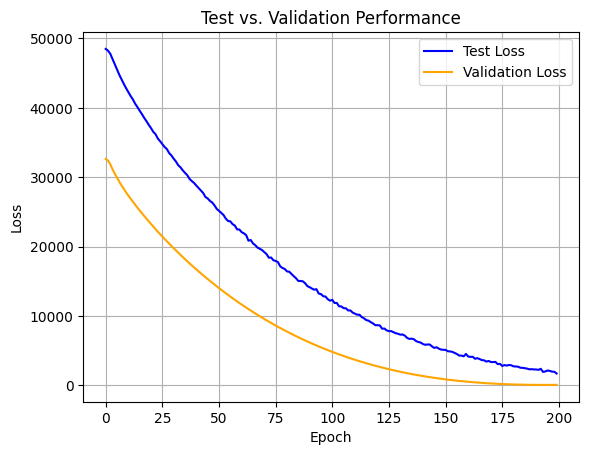

Train indices from 0 to 546 and validation indices from 547 to 818
Epoch [1/200], Loss: 1150.6862, Validation Loss: 29692.3342
Epoch [2/200], Loss: 1053.5090, Validation Loss: 35841.6122
Epoch [3/200], Loss: 1023.5147, Validation Loss: 39252.8334
Epoch [4/200], Loss: 1025.5147, Validation Loss: 45925.2876
Epoch [5/200], Loss: 1023.3857, Validation Loss: 50171.9401
Epoch [6/200], Loss: 1034.5142, Validation Loss: 51208.5104
Epoch [7/200], Loss: 918.6077, Validation Loss: 53805.5427
Epoch [8/200], Loss: 981.5829, Validation Loss: 55185.0639
Epoch [9/200], Loss: 915.4678, Validation Loss: 55276.9918
Epoch [10/200], Loss: 954.5626, Validation Loss: 55404.8369
Epoch [11/200], Loss: 894.6894, Validation Loss: 55398.4530
Early stopping at epoch 11
Best epoch: 1, Best validation loss: 29692.3342


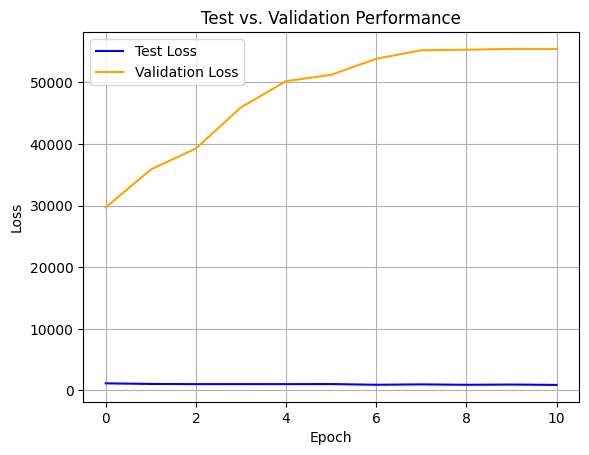

Train indices from 0 to 818 and validation indices from 819 to 1090
Epoch [1/200], Loss: 7557.9058, Validation Loss: 55488.3987
Epoch [2/200], Loss: 5485.9017, Validation Loss: 51199.4227
Epoch [3/200], Loss: 6229.2696, Validation Loss: 33395.9886
Epoch [4/200], Loss: 881.9535, Validation Loss: 284.1060
Epoch [5/200], Loss: 917.3816, Validation Loss: 287.2112
Epoch [6/200], Loss: 849.5103, Validation Loss: 296.2608
Epoch [7/200], Loss: 771.1463, Validation Loss: 295.2938
Epoch [8/200], Loss: 822.9378, Validation Loss: 307.1354
Epoch [9/200], Loss: 737.3525, Validation Loss: 294.4331
Epoch [10/200], Loss: 784.2943, Validation Loss: 295.7450
Epoch [11/200], Loss: 764.0219, Validation Loss: 303.0595
Epoch [12/200], Loss: 753.3470, Validation Loss: 302.5271
Epoch [13/200], Loss: 730.9679, Validation Loss: 329.3645
Epoch [14/200], Loss: 696.1545, Validation Loss: 346.3526
Early stopping at epoch 14
Best epoch: 4, Best validation loss: 284.1060


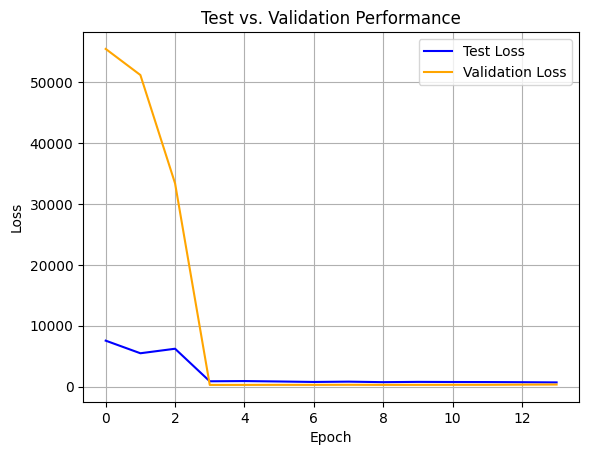

Train indices from 0 to 1090 and validation indices from 1091 to 1362
Epoch [1/200], Loss: 723.2322, Validation Loss: 2707.0715
Epoch [2/200], Loss: 725.6589, Validation Loss: 2521.7181
Epoch [3/200], Loss: 663.6831, Validation Loss: 2424.5020
Epoch [4/200], Loss: 664.6292, Validation Loss: 2308.1966
Epoch [5/200], Loss: 662.1057, Validation Loss: 2277.8450
Epoch [6/200], Loss: 656.3629, Validation Loss: 2071.8066
Epoch [7/200], Loss: 601.7255, Validation Loss: 2088.1960
Epoch [8/200], Loss: 630.8388, Validation Loss: 2002.6712
Epoch [9/200], Loss: 564.2892, Validation Loss: 2221.5699
Epoch [10/200], Loss: 581.3027, Validation Loss: 2098.6594
Epoch [11/200], Loss: 571.2940, Validation Loss: 2167.2869
Epoch [12/200], Loss: 597.6386, Validation Loss: 2235.1143
Epoch [13/200], Loss: 552.3388, Validation Loss: 2183.2169
Epoch [14/200], Loss: 571.0685, Validation Loss: 2226.6661
Epoch [15/200], Loss: 568.3843, Validation Loss: 2178.9235
Epoch [16/200], Loss: 575.9382, Validation Loss: 2176.

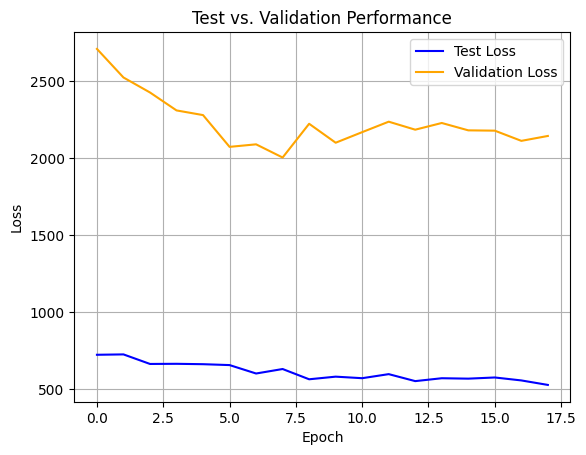

Train indices from 0 to 1362 and validation indices from 1363 to 1634
Epoch [1/200], Loss: 869.8490, Validation Loss: 6369.2354
Epoch [2/200], Loss: 936.9334, Validation Loss: 7463.8667
Epoch [3/200], Loss: 1002.2001, Validation Loss: 7151.7864
Epoch [4/200], Loss: 1735.6696, Validation Loss: 17527.8168
Epoch [5/200], Loss: 3147.5696, Validation Loss: 20260.1643
Epoch [6/200], Loss: 3063.6658, Validation Loss: 15310.7131
Epoch [7/200], Loss: 928.1063, Validation Loss: 7107.2992
Epoch [8/200], Loss: 963.3825, Validation Loss: 6458.5999
Epoch [9/200], Loss: 948.8219, Validation Loss: 5765.4166
Epoch [10/200], Loss: 825.3993, Validation Loss: 5069.6810
Epoch [11/200], Loss: 768.4573, Validation Loss: 4068.0288
Epoch [12/200], Loss: 672.7995, Validation Loss: 3801.2781
Epoch [13/200], Loss: 725.1636, Validation Loss: 3562.0100
Epoch [14/200], Loss: 624.3378, Validation Loss: 3169.8016
Epoch [15/200], Loss: 651.3747, Validation Loss: 2949.3247
Epoch [16/200], Loss: 642.6780, Validation Loss

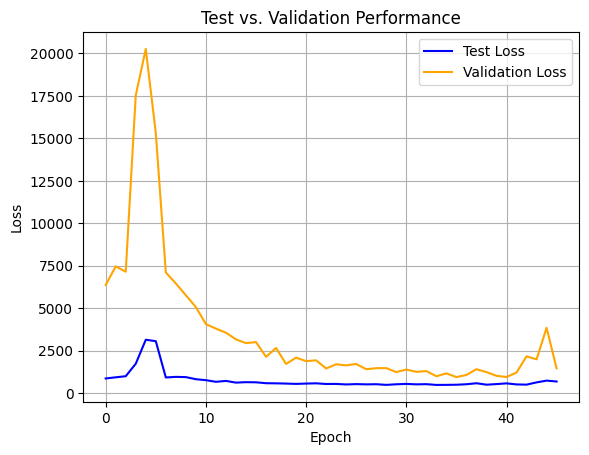

Train indices from 0 to 1634 and validation indices from 1635 to 1906
Epoch [1/200], Loss: 1098.4405, Validation Loss: 4635.5829
Epoch [2/200], Loss: 864.9351, Validation Loss: 3706.4300
Epoch [3/200], Loss: 744.2833, Validation Loss: 4323.4555
Epoch [4/200], Loss: 664.8209, Validation Loss: 1948.8543
Epoch [5/200], Loss: 642.5691, Validation Loss: 2481.6732
Epoch [6/200], Loss: 685.0318, Validation Loss: 1350.2891
Epoch [7/200], Loss: 629.3898, Validation Loss: 2122.3794
Epoch [8/200], Loss: 478.0708, Validation Loss: 1352.7470
Epoch [9/200], Loss: 508.9604, Validation Loss: 1336.8389
Epoch [10/200], Loss: 529.8336, Validation Loss: 1307.1062
Epoch [11/200], Loss: 521.1174, Validation Loss: 1153.1959
Epoch [12/200], Loss: 504.3073, Validation Loss: 1023.6871
Epoch [13/200], Loss: 510.7386, Validation Loss: 1061.9577
Epoch [14/200], Loss: 494.5356, Validation Loss: 1014.3368
Epoch [15/200], Loss: 494.7541, Validation Loss: 825.8233
Epoch [16/200], Loss: 490.1731, Validation Loss: 1101.

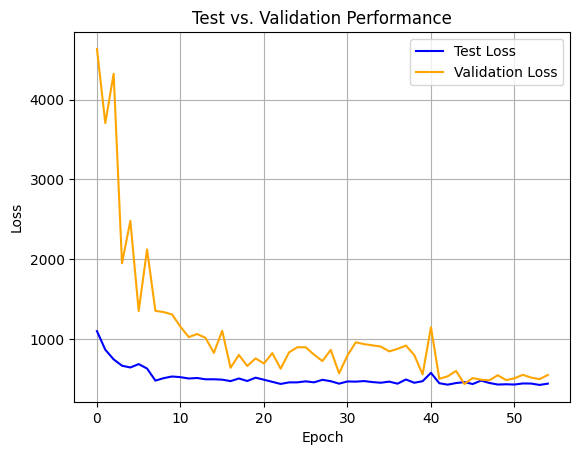

Train indices from 0 to 1906 and validation indices from 1907 to 2178
Epoch [1/200], Loss: 536.5891, Validation Loss: 6486.8297
Epoch [2/200], Loss: 541.2747, Validation Loss: 5083.1195
Epoch [3/200], Loss: 451.9933, Validation Loss: 3149.3405
Epoch [4/200], Loss: 440.1882, Validation Loss: 4340.2958
Epoch [5/200], Loss: 443.6849, Validation Loss: 4261.5224
Epoch [6/200], Loss: 477.1357, Validation Loss: 3694.5488
Epoch [7/200], Loss: 520.7739, Validation Loss: 4564.7835
Epoch [8/200], Loss: 416.7631, Validation Loss: 4141.7126
Epoch [9/200], Loss: 445.3835, Validation Loss: 2830.0226
Epoch [10/200], Loss: 410.2743, Validation Loss: 2929.6910
Epoch [11/200], Loss: 420.6325, Validation Loss: 3983.2094
Epoch [12/200], Loss: 421.4852, Validation Loss: 4095.5801
Epoch [13/200], Loss: 412.7531, Validation Loss: 2625.0765
Epoch [14/200], Loss: 448.4085, Validation Loss: 2674.7480
Epoch [15/200], Loss: 429.1975, Validation Loss: 4674.6276
Epoch [16/200], Loss: 424.1283, Validation Loss: 4350.

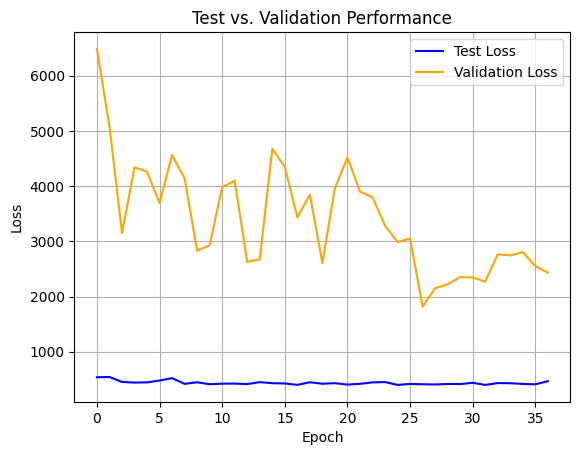

Train indices from 0 to 2178 and validation indices from 2179 to 2450
Epoch [1/200], Loss: 604.0714, Validation Loss: 9027.5322
Epoch [2/200], Loss: 692.6938, Validation Loss: 8546.3518
Epoch [3/200], Loss: 444.7347, Validation Loss: 8657.0832
Epoch [4/200], Loss: 440.6064, Validation Loss: 8567.1364
Epoch [5/200], Loss: 451.0818, Validation Loss: 8723.1662
Epoch [6/200], Loss: 424.8490, Validation Loss: 8360.2341
Epoch [7/200], Loss: 438.2312, Validation Loss: 8487.4010
Epoch [8/200], Loss: 433.6474, Validation Loss: 8391.9520
Epoch [9/200], Loss: 435.5232, Validation Loss: 8281.5264
Epoch [10/200], Loss: 403.0431, Validation Loss: 8346.8944
Epoch [11/200], Loss: 419.5611, Validation Loss: 7916.7702
Epoch [12/200], Loss: 417.0433, Validation Loss: 7940.7159
Epoch [13/200], Loss: 422.0281, Validation Loss: 7844.6654
Epoch [14/200], Loss: 494.4473, Validation Loss: 7293.2928
Epoch [15/200], Loss: 465.2644, Validation Loss: 7738.6624
Epoch [16/200], Loss: 460.4717, Validation Loss: 8037.

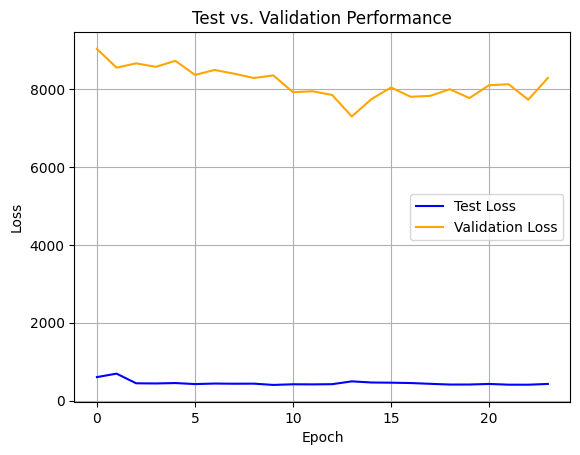

In [7]:
elman_rnn_cv_scores_h32 = training(model=ElmanRNN(input_size=8, hidden_size=32, output_size=1, dropout=0.2),
         data=data,
         target_feature_name='ClosingPrice',
         model_name='elman',
         learning_rate=0.002,
         patience=10,
         num_epochs=200,
         min_delta=10)

In [15]:
elman_rnn_cv_scores_h32
describe_cv_results(elman_rnn_cv_scores_h32, 'Elman RNN with 32 hidden units and dropout 0.02').round(2).to_csv('../csv-descriptions/cv-results-apple-elman-h32-dropout.csv', index=False)

In [18]:
jordan_cv_scores_h32_dropout
describe_cv_results(jordan_cv_scores_h32_dropout, 'Jordan RNN with 32 hidden units and dropout 0.2').round(2).to_csv('../csv-descriptions/cv-results-apple-jordan-h32-dropout.csv', index=False)

(2514, 8)
(2514,)
(2451, 64, 8)
(2451,)
Train indices from 0 to 274 and validation indices from 275 to 546
Epoch [1/200], Loss: 48485.4542, Validation Loss: 32567.6689
Epoch [2/200], Loss: 48203.7203, Validation Loss: 32132.4183
Epoch [3/200], Loss: 47533.9036, Validation Loss: 31547.4454
Epoch [4/200], Loss: 46752.8941, Validation Loss: 30913.4908
Epoch [5/200], Loss: 46029.7654, Validation Loss: 30322.0206
Epoch [6/200], Loss: 45329.2727, Validation Loss: 29760.8393
Epoch [7/200], Loss: 44612.4641, Validation Loss: 29228.4269
Epoch [8/200], Loss: 43976.8762, Validation Loss: 28727.2349
Epoch [9/200], Loss: 43377.1293, Validation Loss: 28246.9614
Epoch [10/200], Loss: 42817.7091, Validation Loss: 27787.1858
Epoch [11/200], Loss: 42196.5178, Validation Loss: 27341.1669
Epoch [12/200], Loss: 41719.9774, Validation Loss: 26909.3302
Epoch [13/200], Loss: 41159.8428, Validation Loss: 26488.2117
Epoch [14/200], Loss: 40666.6682, Validation Loss: 26075.6062
Epoch [15/200], Loss: 40136.4686, 

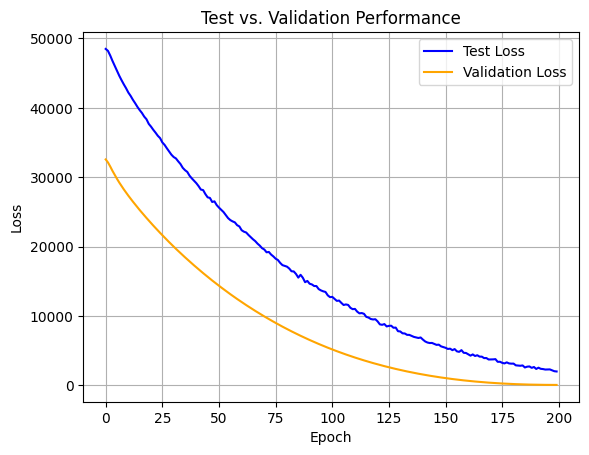

Train indices from 0 to 546 and validation indices from 547 to 818
Epoch [1/200], Loss: 1221.3451, Validation Loss: 1093.7093
Epoch [2/200], Loss: 1136.4511, Validation Loss: 5464.3840
Epoch [3/200], Loss: 1193.4141, Validation Loss: 14141.7616
Epoch [4/200], Loss: 1132.1264, Validation Loss: 25347.7491
Epoch [5/200], Loss: 1160.1399, Validation Loss: 31258.2856
Epoch [6/200], Loss: 1081.4271, Validation Loss: 38469.1645
Epoch [7/200], Loss: 1055.0315, Validation Loss: 44008.7291
Epoch [8/200], Loss: 1022.3586, Validation Loss: 48627.4784
Epoch [9/200], Loss: 907.5203, Validation Loss: 52548.8790
Epoch [10/200], Loss: 993.8531, Validation Loss: 55193.7624
Epoch [11/200], Loss: 992.4161, Validation Loss: 59283.2203
Early stopping at epoch 11
Best epoch: 1, Best validation loss: 1093.7093


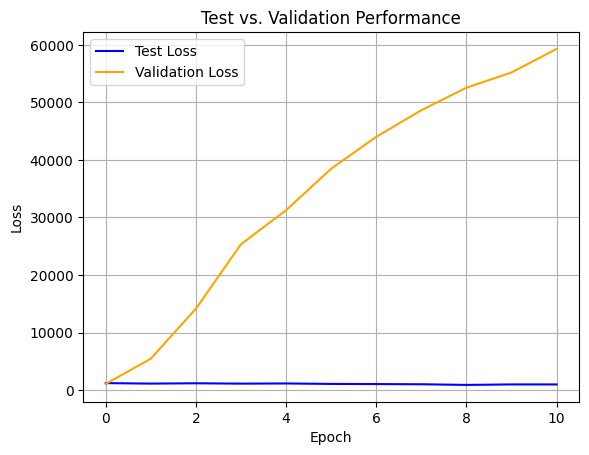

Train indices from 0 to 818 and validation indices from 819 to 1090
Epoch [1/200], Loss: 2588.7606, Validation Loss: 59590.3992
Epoch [2/200], Loss: 12557.2522, Validation Loss: 58910.6697
Epoch [3/200], Loss: 10164.5066, Validation Loss: 58240.9494
Epoch [4/200], Loss: 7396.1043, Validation Loss: 44477.1913
Epoch [5/200], Loss: 4373.9046, Validation Loss: 8601.3631
Epoch [6/200], Loss: 1695.5848, Validation Loss: 964.2911
Epoch [7/200], Loss: 1095.8625, Validation Loss: 930.9264
Epoch [8/200], Loss: 1153.4944, Validation Loss: 1034.1325
Epoch [9/200], Loss: 1035.0645, Validation Loss: 927.9539
Epoch [10/200], Loss: 989.0264, Validation Loss: 899.5082
Epoch [11/200], Loss: 905.9298, Validation Loss: 1003.3649
Epoch [12/200], Loss: 821.5937, Validation Loss: 1003.8223
Epoch [13/200], Loss: 771.1409, Validation Loss: 1414.5290
Epoch [14/200], Loss: 793.1998, Validation Loss: 1009.7070
Epoch [15/200], Loss: 749.3229, Validation Loss: 1032.4036
Epoch [16/200], Loss: 919.5091, Validation Lo

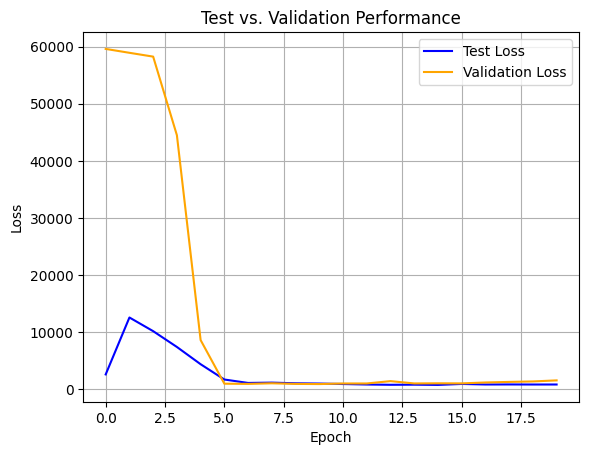

Train indices from 0 to 1090 and validation indices from 1091 to 1362
Epoch [1/200], Loss: 850.5976, Validation Loss: 2334.4928
Epoch [2/200], Loss: 786.2740, Validation Loss: 2103.9698
Epoch [3/200], Loss: 693.1671, Validation Loss: 2190.5995
Epoch [4/200], Loss: 715.0068, Validation Loss: 2154.9815
Epoch [5/200], Loss: 632.6452, Validation Loss: 2201.8250
Epoch [6/200], Loss: 692.2333, Validation Loss: 1859.8954
Epoch [7/200], Loss: 649.9863, Validation Loss: 1955.4111
Epoch [8/200], Loss: 649.7573, Validation Loss: 1773.4221
Epoch [9/200], Loss: 657.5199, Validation Loss: 1785.0412
Epoch [10/200], Loss: 725.7670, Validation Loss: 1605.3767
Epoch [11/200], Loss: 596.4510, Validation Loss: 1584.1303
Epoch [12/200], Loss: 643.8891, Validation Loss: 1655.6513
Epoch [13/200], Loss: 580.3283, Validation Loss: 1666.3222
Epoch [14/200], Loss: 625.3060, Validation Loss: 1495.7230
Epoch [15/200], Loss: 624.6192, Validation Loss: 1519.7873
Epoch [16/200], Loss: 601.4684, Validation Loss: 1610.

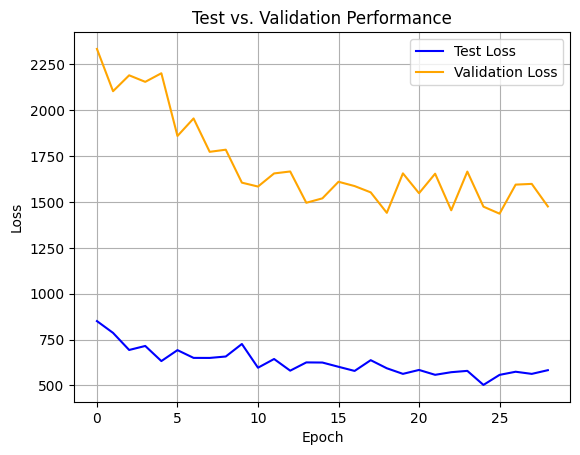

Train indices from 0 to 1362 and validation indices from 1363 to 1634
Epoch [1/200], Loss: 790.5403, Validation Loss: 7062.6237
Epoch [2/200], Loss: 1031.6461, Validation Loss: 8661.7352
Epoch [3/200], Loss: 846.0873, Validation Loss: 7575.1274
Epoch [4/200], Loss: 809.3505, Validation Loss: 6879.7678
Epoch [5/200], Loss: 774.3758, Validation Loss: 6440.0294
Epoch [6/200], Loss: 713.5557, Validation Loss: 5829.0062
Epoch [7/200], Loss: 735.3066, Validation Loss: 5316.8885
Epoch [8/200], Loss: 710.1895, Validation Loss: 4975.9105
Epoch [9/200], Loss: 657.6606, Validation Loss: 4559.5892
Epoch [10/200], Loss: 619.0897, Validation Loss: 3969.6971
Epoch [11/200], Loss: 667.3836, Validation Loss: 3395.9566
Epoch [12/200], Loss: 614.6029, Validation Loss: 3175.7779
Epoch [13/200], Loss: 597.9298, Validation Loss: 2798.8780
Epoch [14/200], Loss: 544.3885, Validation Loss: 2700.4771
Epoch [15/200], Loss: 583.5130, Validation Loss: 2651.3833
Epoch [16/200], Loss: 537.0724, Validation Loss: 2479

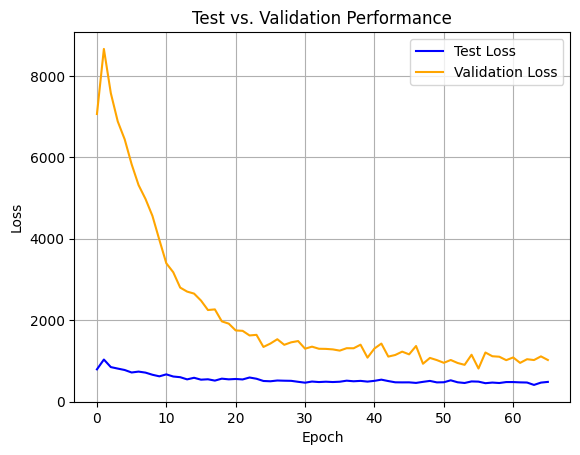

Train indices from 0 to 1634 and validation indices from 1635 to 1906
Epoch [1/200], Loss: 605.4280, Validation Loss: 2729.2172
Epoch [2/200], Loss: 791.6151, Validation Loss: 2226.4897
Epoch [3/200], Loss: 675.3459, Validation Loss: 1927.3175
Epoch [4/200], Loss: 602.7699, Validation Loss: 1606.4829
Epoch [5/200], Loss: 525.7647, Validation Loss: 1490.7550
Epoch [6/200], Loss: 525.2153, Validation Loss: 1276.7128
Epoch [7/200], Loss: 520.2674, Validation Loss: 1083.5820
Epoch [8/200], Loss: 462.9155, Validation Loss: 898.3900
Epoch [9/200], Loss: 460.1170, Validation Loss: 935.1121
Epoch [10/200], Loss: 485.6538, Validation Loss: 799.6586
Epoch [11/200], Loss: 450.6547, Validation Loss: 801.3328
Epoch [12/200], Loss: 500.5124, Validation Loss: 734.9220
Epoch [13/200], Loss: 435.3280, Validation Loss: 741.4525
Epoch [14/200], Loss: 479.5400, Validation Loss: 631.3103
Epoch [15/200], Loss: 454.5266, Validation Loss: 552.6872
Epoch [16/200], Loss: 440.7896, Validation Loss: 500.7525
Epoc

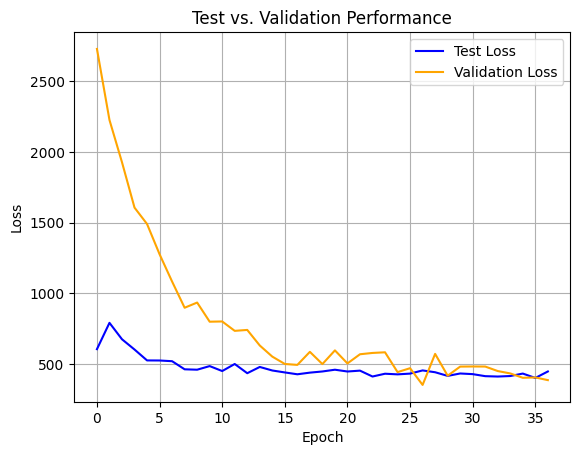

Train indices from 0 to 1906 and validation indices from 1907 to 2178
Epoch [1/200], Loss: 496.8469, Validation Loss: 3916.4676
Epoch [2/200], Loss: 569.1923, Validation Loss: 3985.9515
Epoch [3/200], Loss: 488.3712, Validation Loss: 4004.6440
Epoch [4/200], Loss: 491.0825, Validation Loss: 3676.6665
Epoch [5/200], Loss: 474.4126, Validation Loss: 3637.9235
Epoch [6/200], Loss: 485.0638, Validation Loss: 3618.3621
Epoch [7/200], Loss: 430.5917, Validation Loss: 3355.5776
Epoch [8/200], Loss: 454.6221, Validation Loss: 3166.2462
Epoch [9/200], Loss: 479.2748, Validation Loss: 2814.6116
Epoch [10/200], Loss: 468.2408, Validation Loss: 2913.0268
Epoch [11/200], Loss: 435.5410, Validation Loss: 2419.9344
Epoch [12/200], Loss: 441.1440, Validation Loss: 2521.9525
Epoch [13/200], Loss: 415.2098, Validation Loss: 1896.2685
Epoch [14/200], Loss: 434.7193, Validation Loss: 2309.3338
Epoch [15/200], Loss: 424.4071, Validation Loss: 2548.7643
Epoch [16/200], Loss: 454.0805, Validation Loss: 2268.

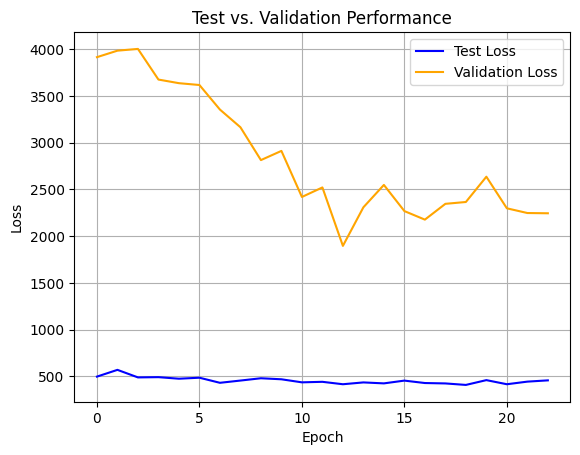

Train indices from 0 to 2178 and validation indices from 2179 to 2450
Epoch [1/200], Loss: 625.7866, Validation Loss: 6967.4061
Epoch [2/200], Loss: 837.5389, Validation Loss: 9136.4173
Epoch [3/200], Loss: 722.5269, Validation Loss: 8481.2886
Epoch [4/200], Loss: 615.2953, Validation Loss: 7428.1055
Epoch [5/200], Loss: 566.2045, Validation Loss: 6641.6453
Epoch [6/200], Loss: 524.1486, Validation Loss: 6131.9699
Epoch [7/200], Loss: 522.1917, Validation Loss: 6018.6315
Epoch [8/200], Loss: 520.7594, Validation Loss: 5264.8871
Epoch [9/200], Loss: 488.1852, Validation Loss: 4930.9606
Epoch [10/200], Loss: 526.7392, Validation Loss: 5004.5324
Epoch [11/200], Loss: 509.7562, Validation Loss: 4550.6213
Epoch [12/200], Loss: 541.2938, Validation Loss: 5026.1977
Epoch [13/200], Loss: 511.2540, Validation Loss: 4472.9247
Epoch [14/200], Loss: 496.1711, Validation Loss: 3755.7673
Epoch [15/200], Loss: 508.6202, Validation Loss: 4307.7997
Epoch [16/200], Loss: 475.8989, Validation Loss: 4244.

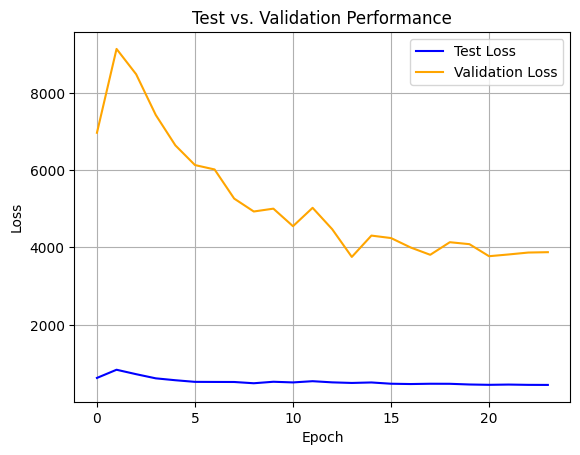

In [17]:
jordan_cv_scores_h32_dropout =training(model=JordanRNN(input_size=8, hidden_size=32, output_size=1, state_size=16, dropout=0.2),
         data=data,
         target_feature_name='ClosingPrice',
         model_name='jordan',
         learning_rate=0.002,
         patience=10,
         num_epochs=200,
         min_delta=10)